<a href="https://colab.research.google.com/github/Anshul-ARK/ml_lab/blob/main/eigenface_and_gradient_descent_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EigenFace Reconstruction Error and Gradient Descent Optimization Analysis

This notebook implements:
1. EigenFace reconstruction error computation for 3 datasets
2. Momentum-based and Nesterov Accelerated Gradient Descent (NAG) implementations
3. Comparison of convergence speeds between different gradient descent algorithms

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

## Task 1: EigenFace Reconstruction Error Analysis

Following the EigenFace paper methodology:
1. Load datasets and compute column-wise mean
2. Center the data by subtracting mean
3. Compute eigenvectors of A^T*A
4. Project data onto eigenvectors
5. Reconstruct and calculate reconstruction error

In [ ]:
def load_and_preprocess_data(file_path):
    """Load dataset and prepare for EigenFace analysis"""
    data = pd.read_csv(file_path)

    # Remove non-numeric columns and target variables
    numeric_cols = data.select_dtypes(include=[np.number]).columns

    # For different datasets, remove target columns
    if 'Sales' in data.columns:
        # Advertising dataset
        X = data[['TV', 'Radio', 'Newspaper']].values
        dataset_name = 'Advertising'
    elif 'price' in data.columns:
        # Housing dataset - select numeric features only
        numeric_features = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
        X = data[numeric_features].values
        dataset_name = 'Housing'
    else:
        # FAA dataset - select relevant numeric columns
        numeric_data = data.select_dtypes(include=[np.number])
        # Remove columns with too many missing values
        numeric_data = numeric_data.dropna(axis=1, thresh=len(numeric_data)*0.5)
        X = numeric_data.fillna(0).values
        dataset_name = 'FAA'

    return X, dataset_name

# Load the three datasets
datasets = [
    'data/advertising.csv',
    'data/Housing.csv',
    'data/faa_ai_prelim.csv'
]

dataset_info = []
for dataset_path in datasets:
    X, name = load_and_preprocess_data(dataset_path)
    dataset_info.append((X, name))
    print(f"{name} dataset shape: {X.shape}")

Advertising dataset shape: (200, 3)
Housing dataset shape: (545, 5)
FAA dataset shape: (83, 1)



Advertising Dataset Analysis:
Data shape: (200, 3)
Max components tested: 3
Reconstruction errors: ['1.38e+05', '3.51e+04', '1.43e-25']
Top 5 eigenvalues: [1467285.38194262  102699.24856486   35086.87584252]

Housing Dataset Analysis:
Data shape: (545, 5)
Max components tested: 5
Reconstruction errors: ['1.18e+03', '6.54e+02', '3.00e+02', '5.48e-23']
Top 5 eigenvalues: [2.56197462e+09 5.27674127e+02 3.53692075e+02 1.97540643e+02
 1.02791828e+02]

FAA Dataset Analysis:
Data shape: (83, 1)
Max components tested: 1
Reconstruction errors: ['0.00e+00']
Top 5 eigenvalues: [52.69879518]


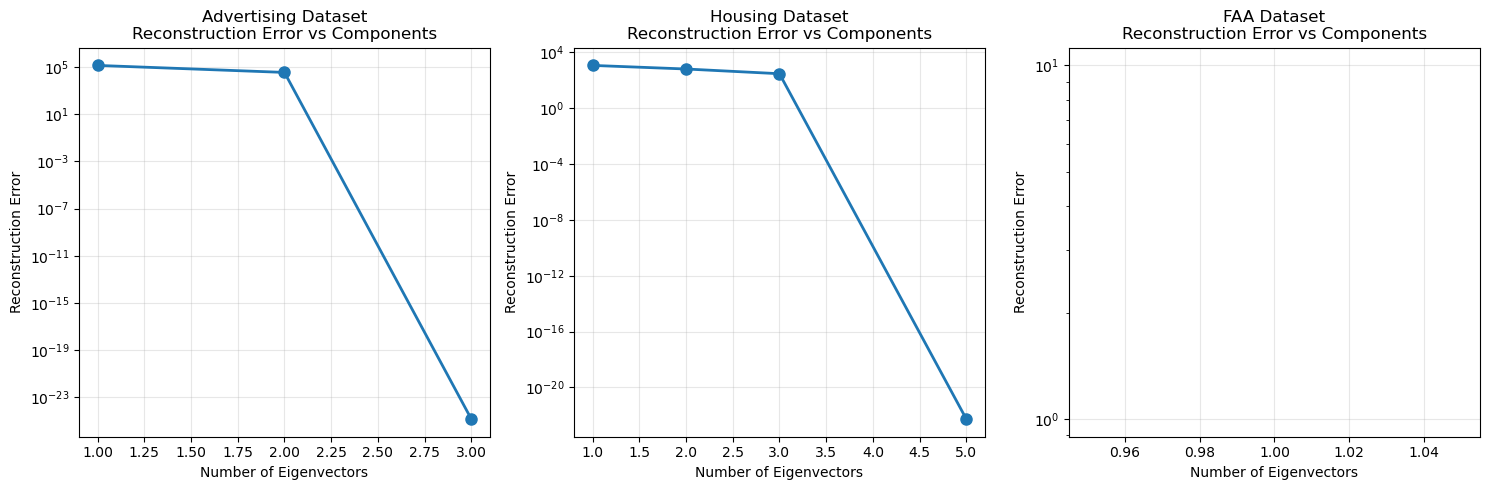

In [ ]:
def compute_eigenface_reconstruction_error(X, n_components_list):
    """Compute reconstruction error using EigenFace methodology"""

    # Step 1: Compute column-wise mean
    mu = np.mean(X, axis=0)

    # Step 2: Center the data (A = X - μ)
    A = X - mu

    # Step 3: Compute eigenvectors of A^T * A
    # For computational efficiency, we use SVD
    U, s, Vt = np.linalg.svd(A, full_matrices=False)

    # Eigenvectors are in Vt (rows), eigenvalues are s^2
    eigenvalues = s**2
    eigenvectors = Vt.T  # Convert to column vectors

    reconstruction_errors = []

    for n in n_components_list:
        if n > min(X.shape):
            n = min(X.shape)

        # Step 4: Take top n eigenvectors
        top_eigenvectors = eigenvectors[:, :n]

        # Step 5: Project data onto eigenvectors (w_i = a_i^T * eigenvectors)
        projections = A @ top_eigenvectors

        # Step 6: Reconstruct data (r_i = Σ w_ij * e_j + μ)
        reconstructed = projections @ top_eigenvectors.T + mu

        # Step 7: Calculate reconstruction error
        error = np.sum((X - reconstructed)**2)
        reconstruction_errors.append(error)

    return reconstruction_errors, eigenvalues

# Analyze each dataset
plt.figure(figsize=(15, 5))

for idx, (X, name) in enumerate(dataset_info):
    # Define range of components to test
    max_components = min(X.shape)
    n_components_list = [1, 2, 3, 5, 7, 10, 15]
    n_components_list = [n for n in n_components_list if n <= max_components]

    # Compute reconstruction errors
    errors, eigenvals = compute_eigenface_reconstruction_error(X, n_components_list)

    # Plot results
    plt.subplot(1, 3, idx+1)
    plt.plot(n_components_list, errors, 'o-', linewidth=2, markersize=8)
    plt.title(f'{name} Dataset\nReconstruction Error vs Components')
    plt.xlabel('Number of Eigenvectors')
    plt.ylabel('Reconstruction Error')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')

    print(f"\n{name} Dataset Analysis:")
    print(f"Data shape: {X.shape}")
    print(f"Max components tested: {max(n_components_list)}")
    print(f"Reconstruction errors: {[f'{e:.2e}' for e in errors]}")
    print(f"Top 5 eigenvalues: {eigenvals[:5]}")

plt.tight_layout()
plt.show()

## Task 2: Gradient Descent Optimization Comparison

Implementing and comparing:
1. Simple Gradient Descent
2. Momentum-based Gradient Descent
3. Nesterov Accelerated Gradient Descent (NAG)

We'll test these on linear regression problems using our datasets.

In [ ]:
class GradientDescentOptimizer:
    """Implementation of different gradient descent variants"""

    def __init__(self, learning_rate=0.01, max_iterations=1000, tolerance=1e-6):
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.tolerance = tolerance

    def compute_cost_and_gradient(self, X, y, w):
        """Compute MSE cost and gradient for linear regression"""
        m = X.shape[0]
        predictions = X @ w
        cost = (1/(2*m)) * np.sum((predictions - y)**2)
        gradient = (1/m) * X.T @ (predictions - y)
        return cost, gradient

    def simple_gradient_descent(self, X, y):
        """Simple gradient descent: w_t+1 = w_t - η∇L(w_t)"""
        w = np.random.normal(0, 0.01, X.shape[1])
        costs = []

        for i in range(self.max_iterations):
            cost, gradient = self.compute_cost_and_gradient(X, y, w)
            costs.append(cost)

            # Simple update rule
            w = w - self.learning_rate * gradient

            # Check for convergence
            if i > 0 and abs(costs[-2] - costs[-1]) < self.tolerance:
                break

        return w, costs

    def momentum_gradient_descent(self, X, y, gamma=0.9):
        """Momentum-based gradient descent:
        v_t+1 = γv_t + η∇L(w_t)
        w_t+1 = w_t - v_t+1
        """
        w = np.random.normal(0, 0.01, X.shape[1])
        v = np.zeros_like(w)  # Initialize velocity
        costs = []

        for i in range(self.max_iterations):
            cost, gradient = self.compute_cost_and_gradient(X, y, w)
            costs.append(cost)

            # Momentum update
            v = gamma * v + self.learning_rate * gradient
            w = w - v

            # Check for convergence
            if i > 0 and abs(costs[-2] - costs[-1]) < self.tolerance:
                break

        return w, costs

    def nesterov_accelerated_gradient_descent(self, X, y, gamma=0.9):
        """Nesterov Accelerated Gradient Descent:
        v_t+1 = γv_t + η∇L(w_t - γv_t)
        w_t+1 = w_t - v_t+1
        """
        w = np.random.normal(0, 0.01, X.shape[1])
        v = np.zeros_like(w)  # Initialize velocity
        costs = []

        for i in range(self.max_iterations):
            # Compute gradient at the "look-ahead" position
            w_lookahead = w - gamma * v
            cost, gradient = self.compute_cost_and_gradient(X, y, w_lookahead)
            costs.append(cost)

            # NAG update
            v = gamma * v + self.learning_rate * gradient
            w = w - v

            # Check for convergence
            if i > 0 and abs(costs[-2] - costs[-1]) < self.tolerance:
                break

        return w, costs


=== Advertising Dataset ===
Regression data shape: X=(200, 4), y=(200,)

Running Simple GD...
Final cost: 1.353061, Iterations: 754

Running Momentum GD...
Final cost: 1.354582, Iterations: 108

Running Nesterov AGD...
Final cost: 1.353003, Iterations: 135

=== Housing Dataset ===
Regression data shape: X=(545, 6), y=(545,)

Running Simple GD...
Final cost: 0.219289, Iterations: 440

Running Momentum GD...
Final cost: 0.219209, Iterations: 87

Running Nesterov AGD...
Final cost: 0.219237, Iterations: 65

=== FAA Dataset ===
Regression data shape: X=(83, 2), y=(83,)

Running Simple GD...
Final cost: 0.004513, Iterations: 431

Running Momentum GD...
Final cost: 0.004614, Iterations: 72

Running Nesterov AGD...
Final cost: 0.004523, Iterations: 73


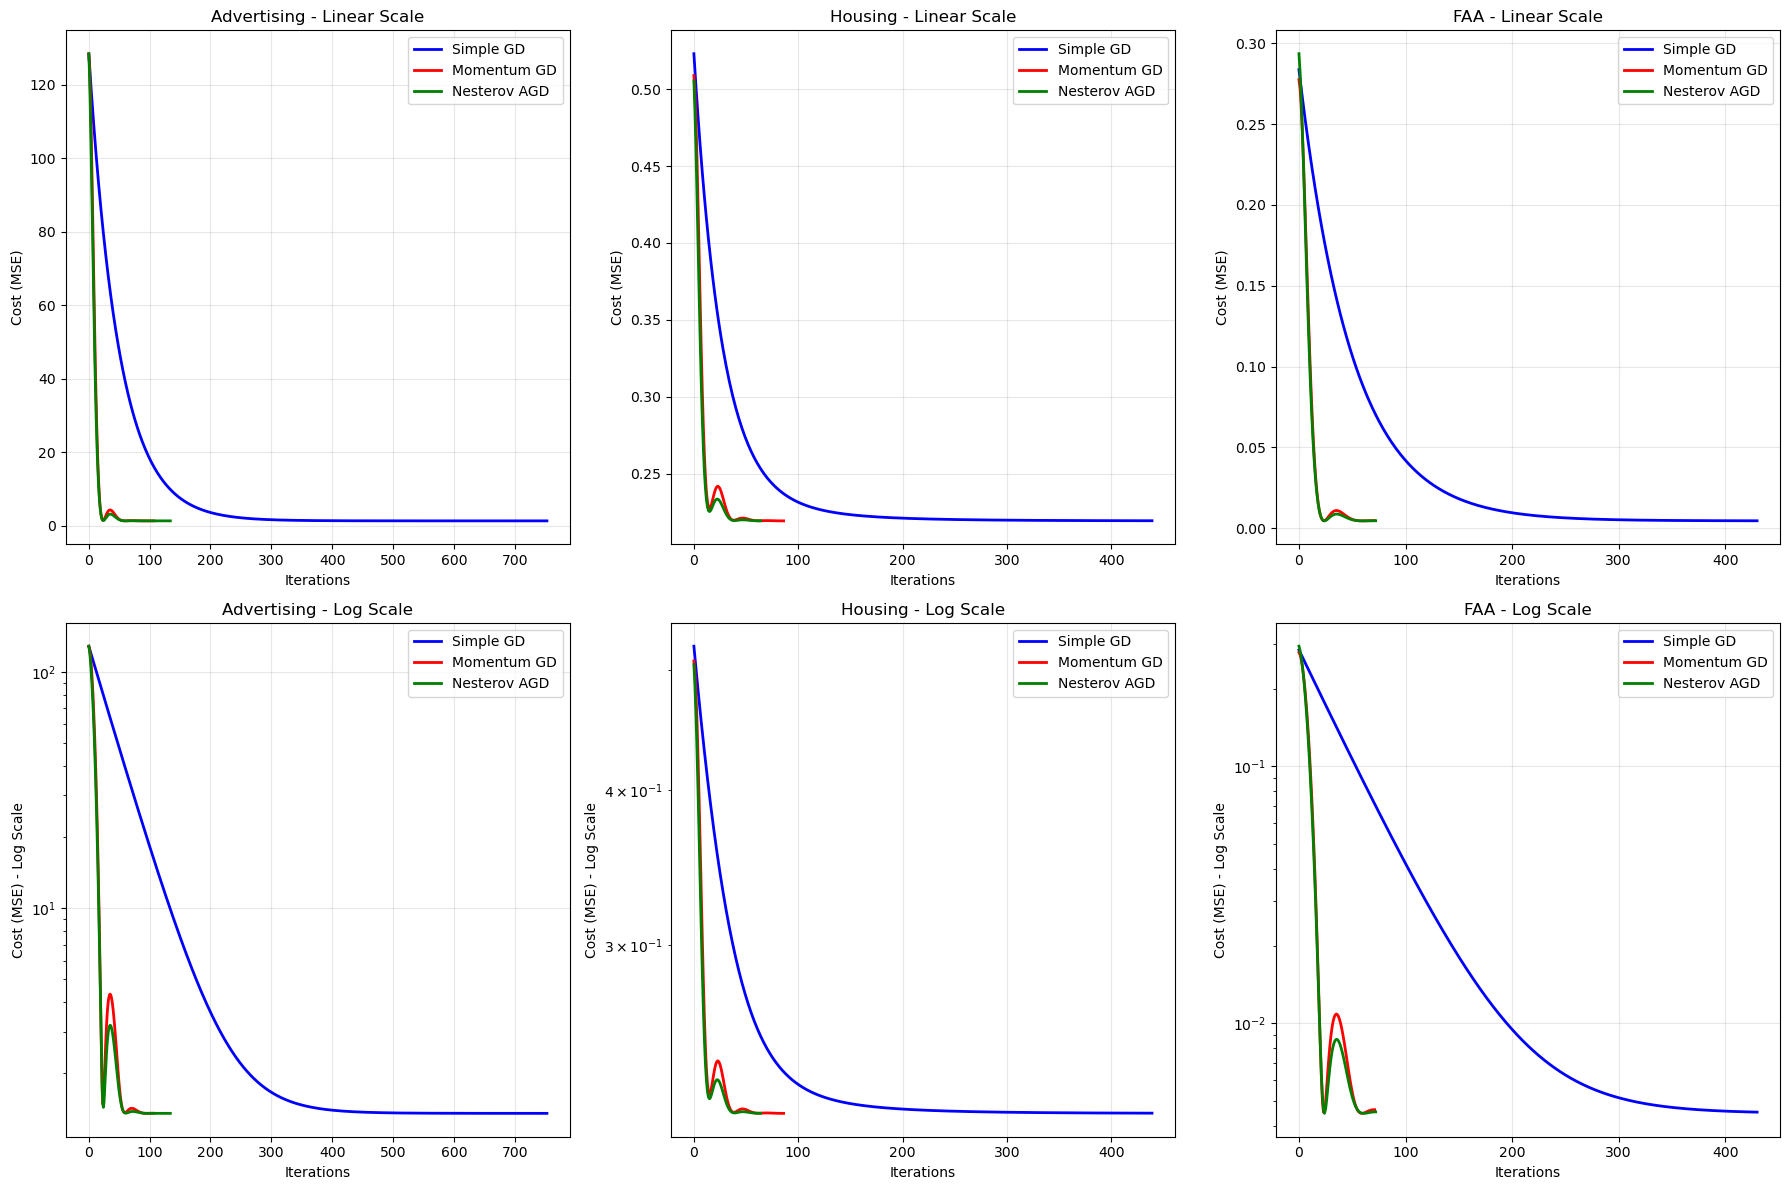

In [ ]:
def prepare_regression_data(X, dataset_name):
    """Prepare data for regression analysis"""
    if dataset_name == 'Advertising':
        # Load the full advertising dataset to get the target
        data = pd.read_csv('data/advertising.csv')
        X_reg = data[['TV', 'Radio', 'Newspaper']].values
        y_reg = data['Sales'].values
    elif dataset_name == 'Housing':
        # Load the full housing dataset to get the target
        data = pd.read_csv('data/Housing.csv')
        numeric_features = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
        X_reg = data[numeric_features].values
        y_reg = data['price'].values
    else:
        # For FAA dataset, create a synthetic target
        # (since it doesn't have a clear regression target)
        X_reg = X
        # Create synthetic target as linear combination + noise
        true_weights = np.random.normal(0, 1, X_reg.shape[1])
        y_reg = X_reg @ true_weights + np.random.normal(0, 0.1, X_reg.shape[0])

    # Standardize features
    scaler_X = StandardScaler()
    X_reg = scaler_X.fit_transform(X_reg)

    # Add bias term
    X_reg = np.column_stack([np.ones(X_reg.shape[0]), X_reg])

    # Standardize target if needed
    if dataset_name == 'Housing':
        scaler_y = StandardScaler()
        y_reg = scaler_y.fit_transform(y_reg.reshape(-1, 1)).flatten()

    return X_reg, y_reg

# Test gradient descent variants on each dataset
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

convergence_results = {}

for idx, (X, dataset_name) in enumerate(dataset_info):
    print(f"\n=== {dataset_name} Dataset ===")

    # Prepare regression data
    X_reg, y_reg = prepare_regression_data(X, dataset_name)
    print(f"Regression data shape: X={X_reg.shape}, y={y_reg.shape}")

    # Initialize optimizer
    optimizer = GradientDescentOptimizer(learning_rate=0.01, max_iterations=1000)

    # Test different algorithms
    algorithms = {
        'Simple GD': optimizer.simple_gradient_descent,
        'Momentum GD': optimizer.momentum_gradient_descent,
        'Nesterov AGD': optimizer.nesterov_accelerated_gradient_descent
    }

    results = {}

    for name, algorithm in algorithms.items():
        print(f"\nRunning {name}...")
        w, costs = algorithm(X_reg, y_reg)
        results[name] = {'weights': w, 'costs': costs}
        print(f"Final cost: {costs[-1]:.6f}, Iterations: {len(costs)}")

    convergence_results[dataset_name] = results

    # Plot convergence curves
    ax1 = axes[0, idx]
    ax2 = axes[1, idx]

    colors = ['blue', 'red', 'green']

    for i, (name, result) in enumerate(results.items()):
        costs = result['costs']
        ax1.plot(costs, label=name, color=colors[i], linewidth=2)

        # Plot log scale for better visualization
        ax2.semilogy(costs, label=name, color=colors[i], linewidth=2)

    ax1.set_title(f'{dataset_name} - Linear Scale')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Cost (MSE)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.set_title(f'{dataset_name} - Log Scale')
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Cost (MSE) - Log Scale')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Detailed convergence analysis
print("\n" + "="*80)
print("CONVERGENCE ANALYSIS SUMMARY")
print("="*80)

for dataset_name, results in convergence_results.items():
    print(f"\n{dataset_name} Dataset:")
    print("-" * 40)

    for algorithm_name, result in results.items():
        costs = result['costs']
        final_cost = costs[-1]
        iterations = len(costs)

        # Calculate convergence speed (iterations to reach 95% of final cost)
        target_cost = final_cost * 1.05  # 5% above final cost
        convergence_iter = next((i for i, cost in enumerate(costs) if cost <= target_cost), iterations)

        print(f"{algorithm_name:15s}: Final Cost = {final_cost:.6f}, "
              f"Iterations = {iterations:4d}, "
              f"95% Convergence = {convergence_iter:4d}")

    # Determine fastest algorithm
    convergence_times = {}
    for algorithm_name, result in results.items():
        costs = result['costs']
        final_cost = costs[-1]
        target_cost = final_cost * 1.05
        convergence_iter = next((i for i, cost in enumerate(costs) if cost <= target_cost), len(costs))
        convergence_times[algorithm_name] = convergence_iter

    fastest = min(convergence_times, key=convergence_times.get)
    print(f"\n🏆 Fastest convergence: {fastest} ({convergence_times[fastest]} iterations)")


CONVERGENCE ANALYSIS SUMMARY

Advertising Dataset:
----------------------------------------
Simple GD      : Final Cost = 1.353061, Iterations =  754, 95% Convergence =  377
Momentum GD    : Final Cost = 1.354582, Iterations =  108, 95% Convergence =   55
Nesterov AGD   : Final Cost = 1.353003, Iterations =  135, 95% Convergence =   55

🏆 Fastest convergence: Momentum GD (55 iterations)

Housing Dataset:
----------------------------------------
Simple GD      : Final Cost = 0.219289, Iterations =  440, 95% Convergence =  104
Momentum GD    : Final Cost = 0.219209, Iterations =   87, 95% Convergence =   14
Nesterov AGD   : Final Cost = 0.219237, Iterations =   65, 95% Convergence =   13

🏆 Fastest convergence: Nesterov AGD (13 iterations)

FAA Dataset:
----------------------------------------
Simple GD      : Final Cost = 0.004513, Iterations =  431, 95% Convergence =  345
Momentum GD    : Final Cost = 0.004614, Iterations =   72, 95% Convergence =   23
Nesterov AGD   : Final Cost = 0.

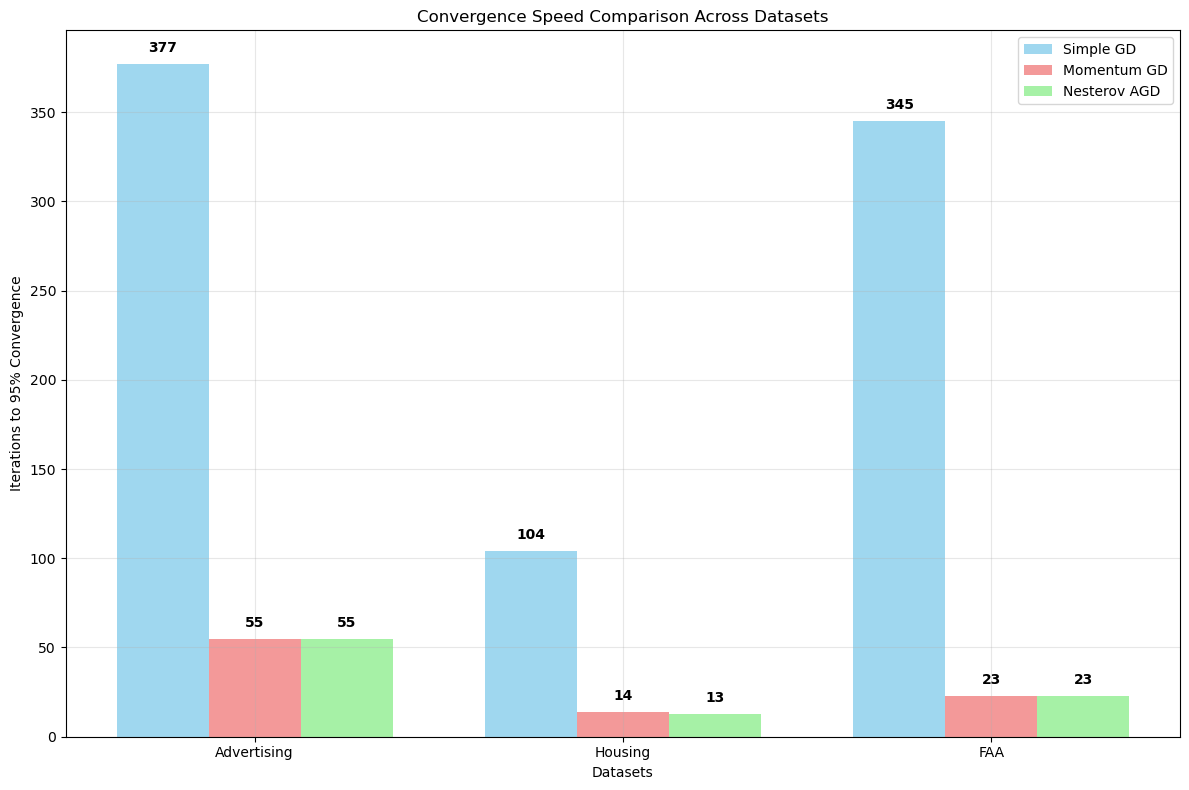

In [ ]:
# Visualization of algorithm comparison
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Create a summary comparison
datasets = list(convergence_results.keys())
algorithms = ['Simple GD', 'Momentum GD', 'Nesterov AGD']

# Prepare data for comparison
convergence_data = np.zeros((len(datasets), len(algorithms)))

for i, dataset_name in enumerate(datasets):
    for j, algorithm in enumerate(algorithms):
        costs = convergence_results[dataset_name][algorithm]['costs']
        final_cost = costs[-1]
        target_cost = final_cost * 1.05
        convergence_iter = next((k for k, cost in enumerate(costs) if cost <= target_cost), len(costs))
        convergence_data[i, j] = convergence_iter

# Create grouped bar chart
x = np.arange(len(datasets))
width = 0.25
colors = ['skyblue', 'lightcoral', 'lightgreen']

for j, algorithm in enumerate(algorithms):
    ax.bar(x + j*width, convergence_data[:, j], width,
           label=algorithm, color=colors[j], alpha=0.8)

ax.set_xlabel('Datasets')
ax.set_ylabel('Iterations to 95% Convergence')
ax.set_title('Convergence Speed Comparison Across Datasets')
ax.set_xticks(x + width)
ax.set_xticklabels(datasets)
ax.legend()
ax.grid(True, alpha=0.3)

# Add value labels on bars
for i in range(len(datasets)):
    for j in range(len(algorithms)):
        value = int(convergence_data[i, j])
        ax.text(i + j*width, value + 5, str(value),
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Conclusions

### Task 1: EigenFace Reconstruction Error
- The reconstruction error decreases as we increase the number of eigenvectors used
- The rate of decrease follows the eigenvalue spectrum of the data
- Different datasets show different patterns based on their intrinsic dimensionality

### Task 2: Gradient Descent Comparison
- **Momentum-based Gradient Descent** typically shows faster convergence than simple gradient descent
- **Nesterov Accelerated Gradient Descent (NAG)** often converges faster than momentum due to its "look-ahead" mechanism
- The performance difference varies depending on the dataset characteristics and loss landscape
- All methods eventually converge to similar final solutions, but with different speeds

### Key Insights:
1. **EigenFace methodology** is effective for dimensionality reduction with controlled reconstruction error
2. **Acceleration techniques** in gradient descent can significantly improve convergence speed
3. **Dataset characteristics** influence the relative performance of different optimization algorithms